### Dépendances

In [ ]:
import json, gzip

import numpy as np
from collections import namedtuple
# Plot libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [ ]:
# Model buildin dependancies
import tensorflow.keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
import tensorflow.keras.optimizers as optimizers

In [ ]:
def plot_loss_acc(history, acc_choice=True):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(3, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()
    if acc_choice:
      acc = history.history['accuracy']

      plt.subplot(3, 1, 2)
      plt.plot(epochs, acc, '.--', label='Training acc')
      final_acc = acc[-1]
      title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      if 'val_accuracy' in history.history:
          val_acc = history.history['val_accuracy']
          plt.plot(epochs, val_acc, 'o-', label='Validation acc')
          final_val_acc = val_acc[-1]
          title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
      plt.title(title)
      plt.legend()
    else :
      acc = history.history['mse']

      plt.subplot(3, 1, 2)
      plt.plot(epochs, acc, '.--', label='Training mse')
      final_acc = acc[-1]
      title = 'Training mse: {:.2f}%'.format(final_acc * 100)
      plt.xlabel('Epochs')
      plt.ylabel('MSE')
      if 'val_mse' in history.history:
          val_acc = history.history['val_mse']
          plt.plot(epochs, val_acc, 'o-', label='Validation mse')
          final_val_acc = val_acc[-1]
          title += ', Validation mse: {:.2f}%'.format(final_val_acc * 100)
      plt.title(title)
      plt.legend()

      mae = history.history['mae']

      plt.subplot(3, 1, 3)
      plt.plot(epochs, mae, '.--', label='Training mae')
      final_mae = mae[-1]
      title = 'Training mae: {:.2f}%'.format(final_acc * 100)
      plt.xlabel('Epochs')
      plt.ylabel('MAE')
      if 'val_mae' in history.history:
          val_acc = history.history['mae']
          plt.plot(epochs, val_acc, 'o-', label='Validation mae')
          final_val_acc = val_acc[-1]
          title += ', Validation mae: {:.2f}%'.format(final_val_acc * 100)
      plt.title(title)
      plt.legend()

### Data Processing

#### Load Dataset

In [ ]:
with gzip.open("samples-9x9.json.gz","r") as f:
  data=json.loads(f.read().decode("utf-8"))

print(len(data),"examples")
print(f"Exemple 0 : {data[0]}")


41563 examples
Exemple 0 : {'depth': 41, 'list_of_moves': ['C6', 'G3', 'D3', 'E7', 'F3', 'G4', 'G7', 'C8', 'F6', 'B6', 'B5', 'E6', 'D5', 'F8', 'H6', 'F2', 'E2', 'H2', 'F5', 'F4', 'E3', 'B7', 'E5', 'G8', 'H8', 'A5', 'G9', 'B4', 'C5', 'H5', 'G5', 'C2', 'H4', 'C7', 'F9', 'E9', 'H9', 'C4', 'F1', 'C3', 'F7'], 'black_stones': ['F9', 'G9', 'H9', 'H8', 'F7', 'G7', 'C6', 'F6', 'H6', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H4', 'D3', 'E3', 'F3', 'E2', 'F1'], 'white_stones': ['E9', 'C8', 'F8', 'G8', 'B7', 'C7', 'E7', 'B6', 'E6', 'A5', 'H5', 'B4', 'C4', 'F4', 'G4', 'C3', 'G3', 'C2', 'F2', 'H2'], 'rollouts': 100, 'black_wins': 84, 'black_points': 1034.0, 'white_wins': 16, 'white_points': 296.0}


#### Create Data structured tuple

In [ ]:
Data = namedtuple('Data', ['x','y'])

#### Data Augmentation : 
Ajout de rotations dans les datas

In [ ]:
gridtoencode = data[0]


def toCoord(s):
  c=ord('I' if s[0]=='J' else s[0])- ord('A')
  l=int(s[1])-1
  return c,l

def arrangeSample(s):
  grid = np.zeros((9,9), dtype="int")
  gridtoencode = s

  for c in gridtoencode["white_stones"]:
    cc = toCoord(c)
    grid[cc[0],cc[1]]=1

  for c in gridtoencode["black_stones"]:
    cc = toCoord(c)
    grid[cc[0],cc[1]]=2

  return Data(grid, s["black_wins"])

print("blacks", [(x,toCoord(x)) for x in gridtoencode["black_stones"]])
print("white", gridtoencode["white_stones"])
print("Score to predict", gridtoencode["black_wins"])

print(arrangeSample(gridtoencode))

datas = [arrangeSample(x) for x in data]

blacks [('F9', (5, 8)), ('G9', (6, 8)), ('H9', (7, 8)), ('H8', (7, 7)), ('F7', (5, 6)), ('G7', (6, 6)), ('C6', (2, 5)), ('F6', (5, 5)), ('H6', (7, 5)), ('B5', (1, 4)), ('C5', (2, 4)), ('D5', (3, 4)), ('E5', (4, 4)), ('F5', (5, 4)), ('G5', (6, 4)), ('H4', (7, 3)), ('D3', (3, 2)), ('E3', (4, 2)), ('F3', (5, 2)), ('E2', (4, 1)), ('F1', (5, 0))]
white ['E9', 'C8', 'F8', 'G8', 'B7', 'C7', 'E7', 'B6', 'E6', 'A5', 'H5', 'B4', 'C4', 'F4', 'G4', 'C3', 'G3', 'C2', 'F2', 'H2']
Score to predict 84
Data(x=array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 2, 1, 1, 0, 0],
       [0, 1, 1, 1, 2, 2, 1, 1, 0],
       [0, 0, 2, 0, 2, 0, 0, 0, 0],
       [0, 2, 2, 0, 2, 1, 1, 0, 1],
       [2, 1, 2, 1, 2, 2, 2, 1, 2],
       [0, 0, 1, 1, 2, 0, 2, 1, 2],
       [0, 1, 0, 2, 1, 2, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]]), y=84)


In [ ]:
def rotation_90(board):
  board_90 = np.zeros((len(board[0]),len(board)))
  for i in range(len(board[0])):
    for j in range(len(board)):
      board_90[i][j]=board[len(board[0])-j-1][i]
  return board_90

def data_rotations(data):
  grid_90 = rotation_90(data.x)
  return Data(grid_90,data.y)

def add_rotations(datas):
  liste = [data_rotations(data) for data in datas]
  return liste

test=[[1,2,3,4,5],
      [6,7,8,9,10],
      [11,12,13,14,15],
      [16,17,18,19,20],
      [21,22,23,24,25]]

print(rotation_90(test))

l = len(datas)
# 4 rotations
liste_90 = add_rotations(datas)
liste_180 = add_rotations(liste_90)
liste_270 = add_rotations(liste_180)
datas = datas + liste_90 + liste_180 + liste_270

# A VOIR
# Symétrie (Oy) + rot (0, 90, 180, 270) checker doublons
# 
#

#print(datas[0])
#print(datas[l])
#print(datas[2 * l])
#print(datas[3 * l])


[[21. 16. 11.  6.  1.]
 [22. 17. 12.  7.  2.]
 [23. 18. 13.  8.  3.]
 [24. 19. 14.  9.  4.]
 [25. 20. 15. 10.  5.]]


#### Data preparation : 
##### From (n,9,9) to (n,9,9,2) 
##### Get feature maps from boards

In [ ]:
x = np.array([datas[i].x for i in range(len(datas))])
y = np.array([datas[i].y for i in range(len(datas))])

In [ ]:
white = np.array(x==1).astype("uint8") #Attention selon Laurent Simon : voir à utiliser des long pour GPU ?
black = np.array(x==2).astype("uint8")

print("White ", white.shape)
print("Black ", black.shape)

x = np.stack([white,black], axis=3)
print("X feature maps ", x.shape)

White  (166252, 9, 9)
Black  (166252, 9, 9)
X feature maps  (166252, 9, 9, 2)


In [ ]:
#print(x[5][:,:,0])

##### Print verification

In [ ]:
def print_fm_verification(x,x_fm):
  print("X")
  print(x[0])
  print("")
  print("X feature maps:")
  print("White (1)")
  print(x_fm[0][:,:,0])
  print("Black (2)")
  print(x_fm[0][:,:,1])

#### Split train/test

In [ ]:
print(f"X shape : {x.shape}, Y shape {y.shape}")

X shape : (166252, 9, 9, 2), Y shape (166252,)


In [ ]:
x_train, y_train = x[:130000], y[:130000]
x_test, y_test = x[130000:], y[130000:]

In [ ]:
print(f"X train : {x_train.shape}, Y train {y_train.shape}")
print(f"X test : {x_test.shape}, Y test {y_test.shape}")

X train : (130000, 9, 9, 2), Y train (130000,)
X test : (36252, 9, 9, 2), Y test (36252,)


## Model preparation

### Modèles

#### Essai (classification avantage N/B)

In [ ]:
model=Sequential()

# Conv1
model.add( Conv2D(filters=64, kernel_size=(5,5), padding="same",input_shape=(9,9,1), activation="relu") )
model.add( MaxPool2D(pool_size=(2,2)) )

for i in range(2):
  model.add( Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu") )
  model.add( MaxPool2D(pool_size=(2,2)) )

model.add(Flatten())

model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(1, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 9, 9, 64)          1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 2, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)               

#### Essai simple + Dropout

In [ ]:
model=Sequential()

# Conv1
model.add( Conv2D(filters=64, kernel_size=(3,3), padding="same",input_shape=(9,9,1), activation="relu") )
# model.add( MaxPool2D(pool_size=(2,2)) )

# Conv 2 à 8
for i in range(7):
  model.add( Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu") )
  #model.add( MaxPool2D(pool_size=(2,2)) )

model.add(Flatten())

model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(1)) #9x9 board for each coord + pass

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 9, 9, 64)          640       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 9, 9, 64)         

#### Modèle sans residual connexion / BN

In [ ]:
model = Sequential()

# Conv1
model.add( Conv2D(filters=128, kernel_size=(5,5), padding="same",input_shape=(9,9,2), activation="relu") )
model.add(BatchNormalization())

# Conv 2 à 8
for _ in range(4):
  model.add( Conv2D(filters=64, kernel_size=(5,5), padding="same", activation="relu") )
  model.add(BatchNormalization())
for _ in range(2):
  model.add( Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu") )
  model.add(BatchNormalization())

model.add( Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu") )
model.add(BatchNormalization())

model.add(Flatten())

for _ in range(3):
  model.add(Dense(512, activation="relu"))
  
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid")) #9x9 board for each coord + pass

model.summary()

model.compile(optimizer="adam", loss="mse", metrics=["mae","mse"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 128)         6528      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          1

### Entrainement

In [ ]:
history = model.fit(x_train, y_train/100.0, epochs=10, verbose=1, batch_size=512, validation_split=0.2)#validation_data=(x_test,y_test))

Epoch 1/10
204/204 [==============================] - 862s 4s/step - loss: 0.0524 - mae: 0.1550 - mse: 0.0524 - val_loss: 0.1220 - val_mae: 0.2973 - val_mse: 0.1220
Epoch 2/10
204/204 [==============================] - 864s 4s/step - loss: 0.0390 - mae: 0.1271 - mse: 0.0390 - val_loss: 0.0629 - val_mae: 0.1873 - val_mse: 0.0629
Epoch 3/10
204/204 [==============================] - 866s 4s/step - loss: 0.0345 - mae: 0.1179 - mse: 0.0345 - val_loss: 0.0534 - val_mae: 0.1345 - val_mse: 0.0534
Epoch 4/10
204/204 [==============================] - 863s 4s/step - loss: 0.0312 - mae: 0.1107 - mse: 0.0312 - val_loss: 0.0399 - val_mae: 0.1142 - val_mse: 0.0399
Epoch 5/10
204/204 [==============================] - 864s 4s/step - loss: 0.0289 - mae: 0.1062 - mse: 0.0289 - val_loss: 0.0378 - val_mae: 0.1148 - val_mse: 0.0378
Epoch 6/10
204/204 [==============================] - 867s 4s/step - loss: 0.0269 - mae: 0.1017 - mse: 0.0269 - val_loss: 0.0451 - val_mae: 0.1178 - val_mse: 0.0451
Epoch 7/10

In [ ]:
#model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
#history = model.fit(x_train, y_train, epochs=30, verbose=1, batch_size=64, validation_split=0.1)

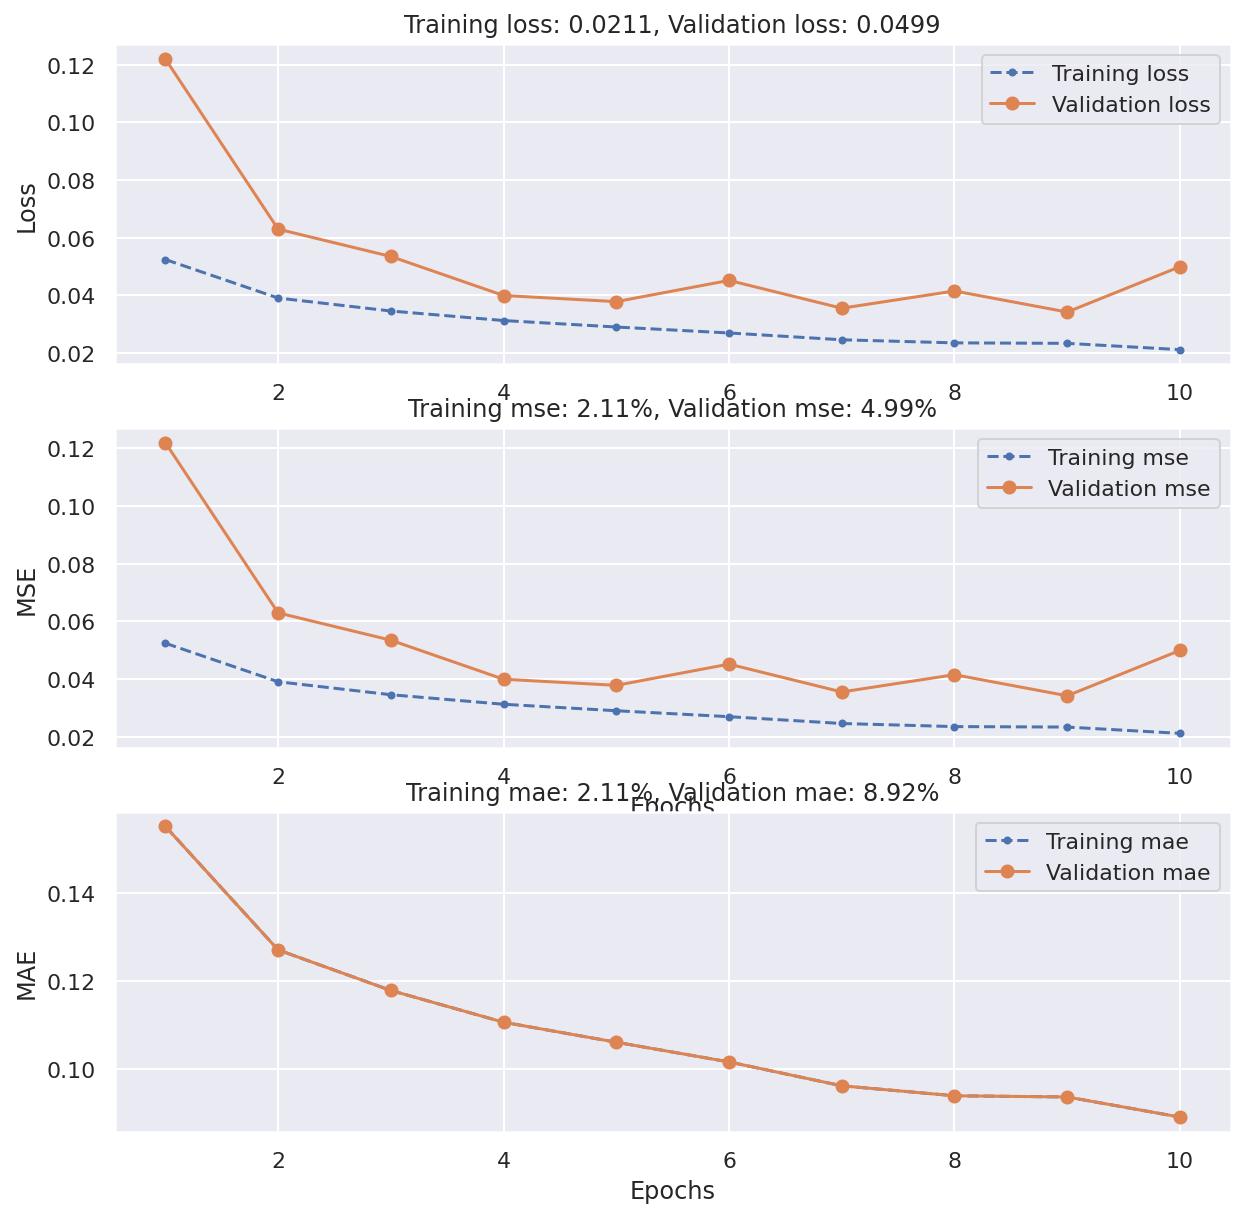

In [ ]:
plot_loss_acc(history, acc_choice=False)

### Verification qualité modèle :
Prédiction sur les données de test

In [ ]:
print(f"Expected {y_test[:5]} \nPredicted : {np.round(model.predict(np.array(x_test[:5]))*100,0).reshape(5)}\n\n")

Expected [ 81  78   0  34 100] 
Predicted : [ 77.  96.   0.  54. 100.]




### Save model

In [ ]:
model_json = model.to_json()
with open("model.json","w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")

In [ ]:
model.save("model_final.h5")

## Load Model

In [ ]:
model=load_model("model_final.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 128)         6528      
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          1

## Model evaluation

In [ ]:
np.round( model.predict(np.array(x_test[:100])) * 100 ,0 ).reshape(100).astype("uint8")

array([ 77,  96,   0,  54, 100,   1,  77, 100,  98,  83,   0,  93,  30,
       100,  68,  85, 100, 100,  61,  30,  52,   0,  74,  63, 100, 100,
         1,  99,  97,  85,  37,  94, 100, 100,  55,  55,   0,  32,  16,
        96, 100,  66,  83,  49,  41,  11,  81,  84,  55,  87,  72,  81,
        86,  99,  69,  77,  37,  60,   0,  50,  57,  30, 100,   0, 100,
       100,  71,  99,   1,  67, 100,  63, 100,  60,   7, 100,   9,   2,
        62, 100,   0,  66, 100,  65,  83, 100, 100,  64,  98,  96,  99,
       100,  63,  52,  52,  69,   0, 100,  34,  72], dtype=uint8)

In [ ]:
def accuracy_delta(delta=20, n=500):
  y_pred = np.round( model.predict(np.array(x_test[:n])) * 100 ,0 ).reshape(n).astype("float")
  y_true = y_test[:n].astype("float")
  #print(f"y_pred : {y_pred}\ny_true : {y_true}")
  #print(y_pred - y_true)
  return (np.abs(y_pred - y_true)<delta).astype("uint8").sum()/n

print(accuracy_delta(delta=20, n=len(x_test)))

0.8281474125565486


## MCTS


In [ ]:
import numpy as np
from collections import defaultdict

from abc import ABC, abstractmethod


class TwoPlayersAbstractGameState(ABC):

    def game_result(self):
        """
        this property should return:
         1 if player #1 wins
        -1 if player #2 wins
         0 if there is a draw
         None if result is unknown
        Returns
        -------
        int
        """
        pass

    def is_game_over(self):
        """
        boolean indicating if the game is over,
        simplest implementation may just be
        `return self.game_result() is not None`
        Returns
        -------
        boolean
        """
        pass

    def move(self, action):
        """
        consumes action and returns resulting TwoPlayersAbstractGameState
        Parameters
        ----------
        action: AbstractGameAction
        Returns
        -------
        TwoPlayersAbstractGameState
        """
        pass

    def get_legal_actions(self):
        """
        returns list of legal action at current game state
        Returns
        -------
        list of AbstractGameAction
        """
        pass



class TwoPlayersGameMonteCarloTreeSearchNode(MonteCarloTreeSearchNode):
    def __init__(self, state, parent=None):
        super().__init__(state, parent)
        self._number_of_visits = 0.
        self._results = defaultdict(int)
        self._untried_actions = None

    @property
    def untried_actions(self):
        if self._untried_actions is None:
            self._untried_actions = self.state.get_legal_actions()
        return self._untried_actions

    @property
    def q(self):
        wins = self._results[self.parent.state.next_to_move]
        loses = self._results[-1 * self.parent.state.next_to_move]
        return wins - loses

    @property
    def n(self):
        return self._number_of_visits

    def expand(self):
        action = self.untried_actions.pop()
        next_state = self.state.move(action)
        child_node = TwoPlayersGameMonteCarloTreeSearchNode(
            next_state, parent=self
        )
        self.children.append(child_node)
        return child_node

    def is_terminal_node(self):
        return self.state.is_game_over()

    def rollout(self):
        current_rollout_state = self.state
        while not current_rollout_state.is_game_over():
            possible_moves = current_rollout_state.get_legal_actions()
            action = self.rollout_policy(possible_moves)
            current_rollout_state = current_rollout_state.move(action)
        return current_rollout_state.game_result

    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results[result] += 1.
        if self.parent:
            self.parent.backpropagate(result)

Rollout

In [ ]:
# Codage du rollout
# Complete one random playout from node
def fin_partie(board):


def rollout(node):
  # On produit donc une partie aléatoire à partir du noeud
  # Implique: --> donner conditions de fin de partie
  # Boucler sous ces conditions l'avancement du board pour donner une note (victoire,defaite,égalité)

  # Partie s'arrête quand deux joueurs passent consécutivement

